In [14]:
#Multi Sector ETFs
import yfinance as yf
import pandas as pd

etf_symbols = ['XLK', 'XLV', 'XLF', 'XLI']  # Tech, Healthcare, Financials, Industrials
start_date = '2015-01-01'
end_date = '2025-06-10'

# Download ETF close prices (columns: ETF tickers, index: Date)
etf_data = yf.download(etf_symbols, start=start_date, end=end_date)['Close']

# Download 5-yr Treasury yield (index: Date)
rate_data = yf.download('^FVX', start=start_date, end=end_date)['Close']

print(etf_data.head())
print(rate_data.head())

C:\Users\tkratt\AppData\Local\Temp\ipykernel_7584\3893832245.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  etf_data = yf.download(etf_symbols, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed
C:\Users\tkratt\AppData\Local\Temp\ipykernel_7584\3893832245.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rate_data = yf.download('^FVX', start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed

Ticker            XLF        XLI        XLK        XLV
Date                                                  
2015-01-02  16.469656  46.692085  36.315063  57.799503
2015-01-05  16.123346  45.601414  35.760696  57.504730
2015-01-06  15.876939  45.039555  35.329525  57.311039
2015-01-07  16.043427  45.378323  35.628716  58.658546
2015-01-08  16.283186  46.287216  36.411854  59.660740
Ticker       ^FVX
Date             
2015-01-02  1.618
2015-01-05  1.568
2015-01-06  1.493
2015-01-07  1.473
2015-01-08  1.496


In [15]:


# If rate_data is a DataFrame, convert it to a Series
if isinstance(rate_data, pd.DataFrame):
    rate_data = rate_data.squeeze()

# --- CALCULATE 1-MONTH (21 TRADING DAYS) CHANGE ---
rate_1m_chg = rate_data.diff(21)

print(rate_1m_chg.head())
# --- FIND DATES WITH ≥50 BPS MOVE OVER 1 MONTH ---
large_move_mask = rate_1m_chg.abs() >= 0.50
large_move_dates_all = rate_1m_chg.index[large_move_mask]

# --- LIMIT TO MAX ONE LARGE MOVE PER MONTH ---
# Convert to a Series to use groupby by month
large_move_series = pd.Series(index=large_move_dates_all, data=rate_1m_chg[large_move_dates_all].values)

# Group by year and month, then take the first date in each group

# For simplicity, let's take the first occurrence within the month
one_move_per_month_dates = large_move_series.groupby([large_move_series.index.year, large_move_series.index.month]).apply(lambda x: x.index[0])

print("\nDates with ≥50 bps move (limited to one per month):")
print(one_move_per_month_dates)
print("There were this many moves this size: " + str(len(one_move_per_month_dates)))

Date
2015-01-02   NaN
2015-01-05   NaN
2015-01-06   NaN
2015-01-07   NaN
2015-01-08   NaN
Name: ^FVX, dtype: float64

Dates with ≥50 bps move (limited to one per month):
Date  Date
2016  11     2016-11-18
      12     2016-12-01
2019  6      2019-06-03
2020  2      2020-02-28
      3      2020-03-02
2022  3      2022-03-22
      4      2022-04-01
      5      2022-05-02
      6      2022-06-13
      7      2022-07-15
      8      2022-08-29
      9      2022-09-01
      10     2022-10-04
      12     2022-12-01
2023  2      2023-02-01
      3      2023-03-01
      4      2023-04-03
      6      2023-06-05
      7      2023-07-06
      10     2023-10-03
      11     2023-11-17
      12     2023-12-01
2024  4      2024-04-10
      8      2024-08-01
      10     2024-10-22
      11     2024-11-01
2025  1      2025-01-10
dtype: datetime64[ns]
There were this many moves this size: 27


In [16]:
periods = {'3m': 21*3, '6m': 21*6, '12m': 21*12}
results = []

for symbol in etf_symbols:
    for event_date in large_move_dates_all:
        if event_date not in etf_data.index:
            continue  # skip if ETF data is missing for that date
        row = {
            'etf': symbol,
            'event_date': event_date,
            'rate_1m_chg': rate_1m_chg.loc[event_date]  # <--- FIXED HERE
        }
        for label, days in periods.items():
            # Forward
            try:
                fwd_idx = etf_data.index.get_loc(event_date) + days
                if fwd_idx < len(etf_data):
                    fwd_return = (etf_data[symbol].iloc[fwd_idx] / etf_data[symbol].loc[event_date]) - 1
                else:
                    fwd_return = None
            except KeyError:
                fwd_return = None
            row[f'{label}_fwd_return'] = fwd_return

            # Backward
            try:
                bwd_idx = etf_data.index.get_loc(event_date) - days
                if bwd_idx >= 0:
                    bwd_return = (etf_data[symbol].loc[event_date] / etf_data[symbol].iloc[bwd_idx]) - 1
                else:
                    bwd_return = None
            except KeyError:
                bwd_return = None
            row[f'{label}_bwd_return'] = bwd_return
        results.append(row)

event_returns = pd.DataFrame(results)


In [17]:
up_events = event_returns[event_returns['rate_1m_chg'] > 0]
down_events = event_returns[event_returns['rate_1m_chg'] < 0]


In [18]:
summary_up = up_events.groupby('etf')[[f'{p}_fwd_return' for p in periods] + [f'{p}_bwd_return' for p in periods]].mean()
summary_down = down_events.groupby('etf')[[f'{p}_fwd_return' for p in periods] + [f'{p}_bwd_return' for p in periods]].mean()
print("Rate Up Events:\n", summary_up)
print("Rate Down Events:\n", summary_down)


Rate Up Events:
      3m_fwd_return  6m_fwd_return  12m_fwd_return  3m_bwd_return  \
etf                                                                
XLF       0.011877      -0.001018        0.075799       0.011371   
XLI       0.025135       0.049982        0.150657       0.007020   
XLK       0.020667       0.075118        0.282404      -0.013665   
XLV       0.032014       0.024490        0.082498      -0.019270   

     6m_bwd_return  12m_bwd_return  
etf                                 
XLF      -0.007314        0.033630  
XLI      -0.000944        0.040865  
XLK      -0.022240        0.026596  
XLV      -0.009988        0.048009  
Rate Down Events:
      3m_fwd_return  6m_fwd_return  12m_fwd_return  3m_bwd_return  \
etf                                                                
XLF       0.075879       0.098914        0.378729      -0.080403   
XLI       0.096253       0.144280        0.358670      -0.055910   
XLK       0.155021       0.262081        0.461256       0.037


--- XLK: Rate Up Event Average Returns ---
  12M Before: 2.66%
  6M Before: -2.22%
  3M Before: -1.37%
  3M Forward: 2.07%
  6M Forward: 7.51%
  12M Forward: 28.24%

--- XLK: Rate Up Event Abnormal Returns ---
 12M Before vs. avg -19.81%
 6M Before vs. avg -12.37%
 3M Before vs. avg -6.19%
 3M Forward vs. avg -2.76%
 6M Forward vs. avg -2.63%
 12M Forward vs. avg 5.77%

--- XLK: Rate Down Event Abnormal Returns ---
 12M Before vs. avg -10.06%
 6M Before vs. avg -3.36%
 3M Before vs. avg -1.08%
 3M Forward vs. avg 10.67%
 6M Forward vs. avg 16.06%
 12M Forward vs. avg 23.66%

--- XLK: Rate Down Event Average Returns ---
  12M Before: 12.41%
  6M Before: 6.78%
  3M Before: 3.75%
  3M Forward: 15.50%
  6M Forward: 26.21%
  12M Forward: 46.13%


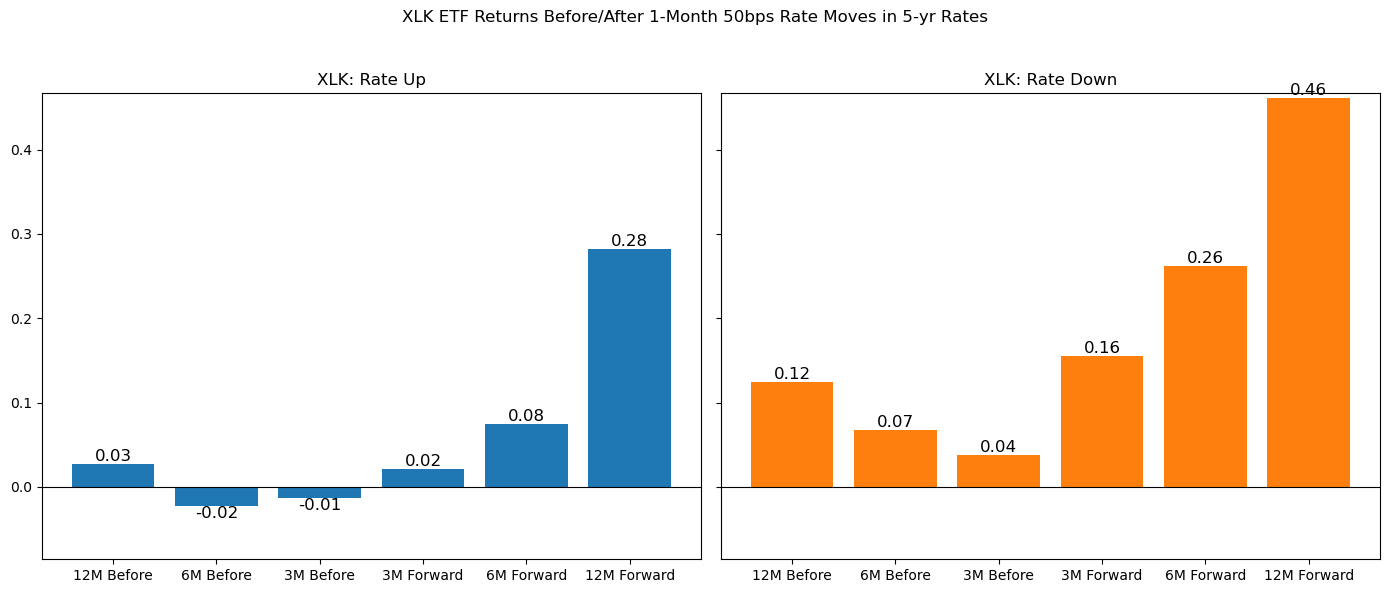


--- XLV: Rate Up Event Average Returns ---
  12M Before: 4.80%
  6M Before: -1.00%
  3M Before: -1.93%
  3M Forward: 3.20%
  6M Forward: 2.45%
  12M Forward: 8.25%

--- XLV: Rate Up Event Abnormal Returns ---
 12M Before vs. avg -5.08%
 6M Before vs. avg -5.48%
 3M Before vs. avg -4.15%
 3M Forward vs. avg 0.98%
 6M Forward vs. avg -2.03%
 12M Forward vs. avg -1.64%

--- XLV: Rate Down Event Abnormal Returns ---
 12M Before vs. avg -9.21%
 6M Before vs. avg -2.0%
 3M Before vs. avg -5.51%
 3M Forward vs. avg 4.24%
 6M Forward vs. avg 4.8%
 12M Forward vs. avg 7.15%

--- XLV: Rate Down Event Average Returns ---
  12M Before: 0.67%
  6M Before: 2.48%
  3M Before: -3.28%
  3M Forward: 6.47%
  6M Forward: 9.27%
  12M Forward: 17.04%


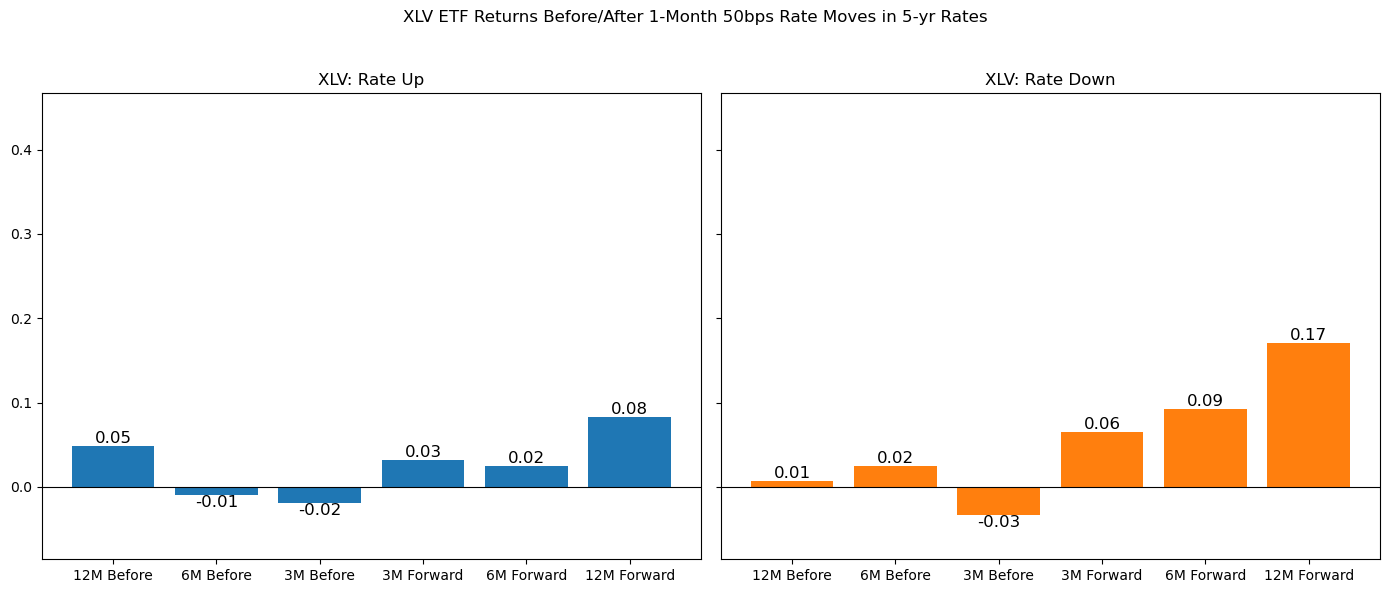


--- XLF: Rate Up Event Average Returns ---
  12M Before: 3.36%
  6M Before: -0.73%
  3M Before: 1.14%
  3M Forward: 1.19%
  6M Forward: -0.10%
  12M Forward: 7.58%

--- XLF: Rate Up Event Abnormal Returns ---
 12M Before vs. avg -10.5%
 6M Before vs. avg -7.4%
 3M Before vs. avg -2.11%
 3M Forward vs. avg -2.06%
 6M Forward vs. avg -6.77%
 12M Forward vs. avg -6.29%

--- XLF: Rate Down Event Abnormal Returns ---
 12M Before vs. avg -19.42%
 6M Before vs. avg -9.39%
 3M Before vs. avg -11.29%
 3M Forward vs. avg 4.34%
 6M Forward vs. avg 3.22%
 12M Forward vs. avg 24.0%

--- XLF: Rate Down Event Average Returns ---
  12M Before: -5.55%
  6M Before: -2.72%
  3M Before: -8.04%
  3M Forward: 7.59%
  6M Forward: 9.89%
  12M Forward: 37.87%


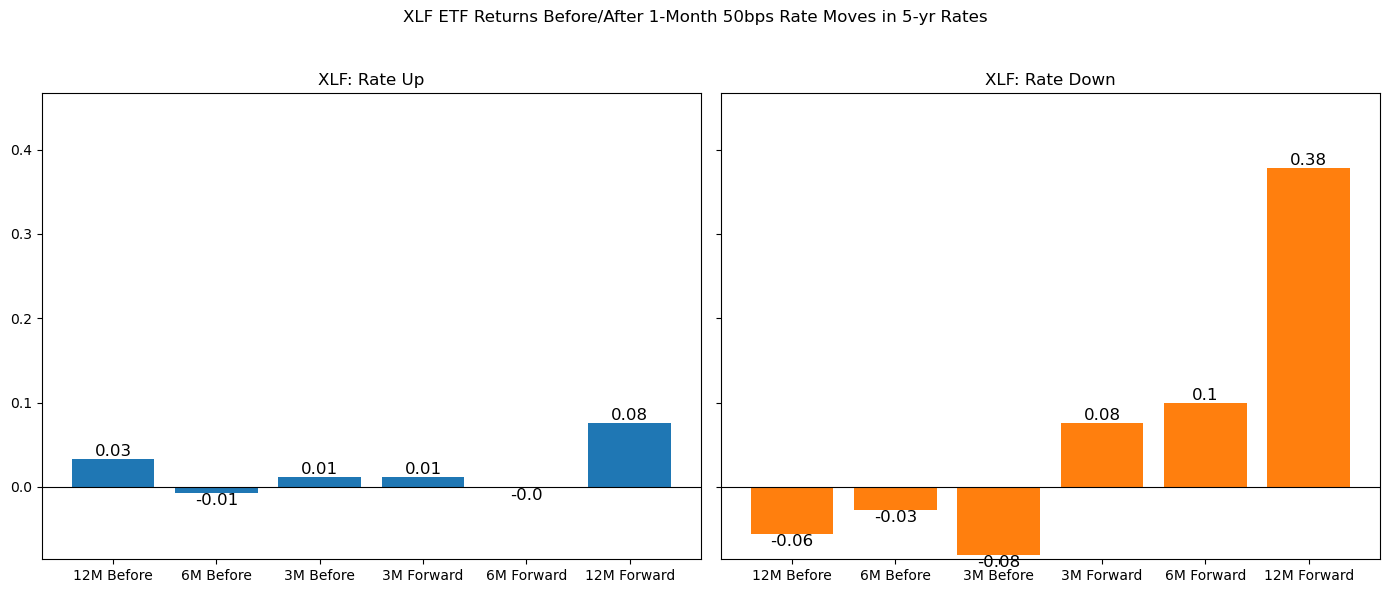


--- XLI: Rate Up Event Average Returns ---
  12M Before: 4.09%
  6M Before: -0.09%
  3M Before: 0.70%
  3M Forward: 2.51%
  6M Forward: 5.00%
  12M Forward: 15.07%

--- XLI: Rate Up Event Abnormal Returns ---
 12M Before vs. avg -9.01%
 6M Before vs. avg -6.19%
 3M Before vs. avg -2.28%
 3M Forward vs. avg -0.47%
 6M Forward vs. avg -1.09%
 12M Forward vs. avg 1.97%

--- XLI: Rate Down Event Abnormal Returns ---
 12M Before vs. avg -15.09%
 6M Before vs. avg -6.32%
 3M Before vs. avg -8.58%
 3M Forward vs. avg 6.64%
 6M Forward vs. avg 8.34%
 12M Forward vs. avg 22.77%

--- XLI: Rate Down Event Average Returns ---
  12M Before: -2.00%
  6M Before: -0.23%
  3M Before: -5.59%
  3M Forward: 9.63%
  6M Forward: 14.43%
  12M Forward: 35.87%


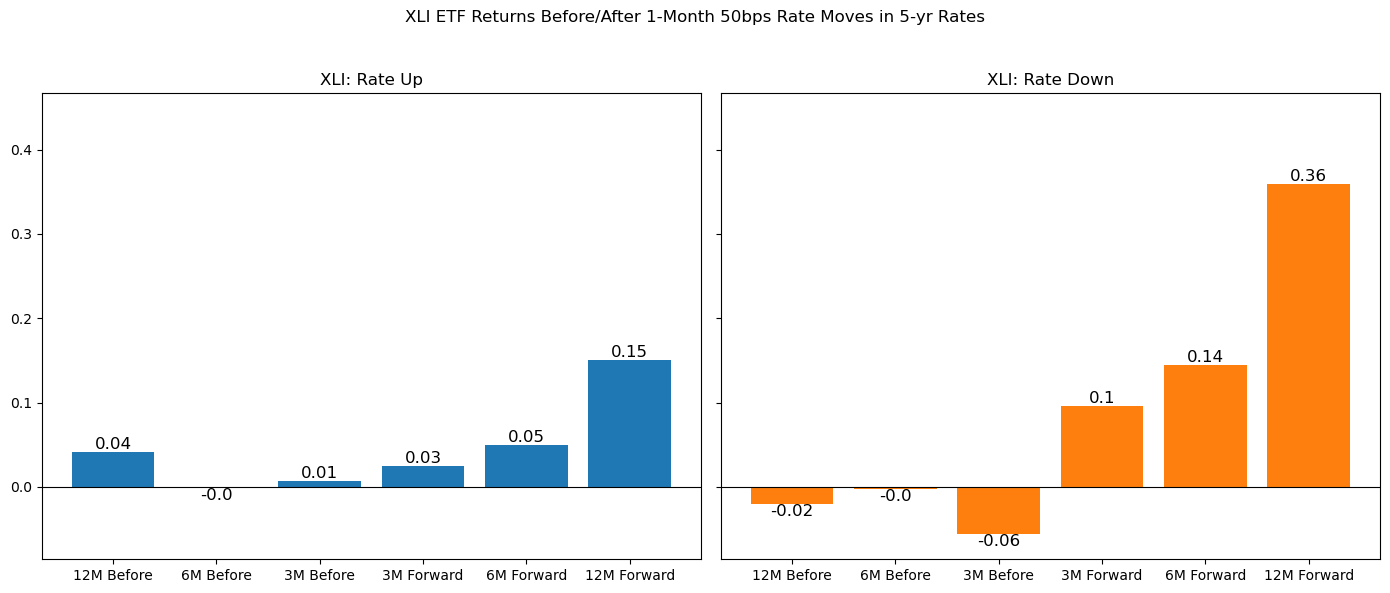

In [25]:
import matplotlib.pyplot as plt
import numpy as np


timeline_order = ['12m_bwd_return', '6m_bwd_return', '3m_bwd_return', '3m_fwd_return', '6m_fwd_return', '12m_fwd_return']
timeline_labels = ['12M Before', '6M Before', '3M Before', '3M Forward', '6M Forward', '12M Forward']

# --- 1. Compute global min and max for y-axis ---
all_means = []
for symbol in etf_symbols:
    etf_up = up_events[up_events['etf'] == symbol]
    mean_up = [etf_up[col].mean() for col in timeline_order]
    all_means.extend(mean_up)
    etf_down = down_events[down_events['etf'] == symbol]
    mean_down = [etf_down[col].mean() for col in timeline_order]
    all_means.extend(mean_down)
ymin = min(all_means)
ymax = max(all_means)

# Optionally, pad the limits a bit for aesthetics
pad = 0.01 * (ymax - ymin)
ymin -= pad
ymax += pad

# --- 2. Plot with fixed y-axis limits and add text on bars ---
for symbol in etf_symbols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Up events
    etf_up = up_events[up_events['etf'] == symbol]
    mean_up = [etf_up[col].mean() for col in timeline_order]

       # --- ADDED PRINT STATEMENT HERE ---
    print(f"\n--- {symbol}: Rate Up Event Average Returns ---")
    for label, value in zip(timeline_labels, mean_up):
        print(f"  {label}: {value:.2%}") # Format to 4 decimal places for precision

    #UP RATE multiple Prting
    print(f"\n--- {symbol}: Rate Up Event Abnormal Returns ---")
    for label, value in zip(timeline_labels, mean_up):
       # Format to 4 decimal places for precision
        print(f" {label} vs. avg {round((value-avg_returns_df[time_key[label]].iloc[key[symbol]])*100,2)}%")
    # --- END ADDED PRINT STATEMENT ---
    bars_up = axs[0].bar(timeline_labels, mean_up, color='tab:blue')
    axs[0].set_title(f'{symbol}: Rate Up')
    axs[0].axhline(0, color='black', linewidth=0.8)
    axs[0].set_ylim(ymin, ymax)  # Set y-axis limits

    # Add text labels on top of bars for Up events
    for bar in bars_up:
        yval = bar.get_height()
        # Adjust text position slightly based on positive/negative value
        va = 'bottom' if yval >= 0 else 'top'
        axs[0].text(bar.get_x() + bar.get_width()/2, yval, 
                    round(yval, 2), # Format to 2 decimal places
                    ha='center', va=va, fontsize=12, color='black')


    # Down events
    etf_down = down_events[down_events['etf'] == symbol]
    mean_down = [etf_down[col].mean() for col in timeline_order]

      # --- ADDED PRINT STATEMENT HERE ---
    #DOWN RATE multiple print 
    print(f"\n--- {symbol}: Rate Down Event Abnormal Returns ---")
    for label, value in zip(timeline_labels, mean_down):
       # Format to 4 decimal places for precision
        print(f" {label} vs. avg {round((value-avg_returns_df[time_key[label]].iloc[key[symbol]])*100,2)}%")
    
    
    print(f"\n--- {symbol}: Rate Down Event Average Returns ---")
    for label, value in zip(timeline_labels, mean_down):
        print(f"  {label}: {value:.2%}") # Format to 4 decimal places for precision


    
    # --- END ADDED PRINT STATEMENT ---
    
    bars_down = axs[1].bar(timeline_labels, mean_down, color='tab:orange')
    axs[1].set_title(f'{symbol}: Rate Down')
    axs[1].axhline(0, color='black', linewidth=0.8)
    axs[1].set_ylim(ymin, ymax)  # Set y-axis limits

    # Add text labels on top of bars for Down events
    for bar in bars_down:
        yval = bar.get_height()
        # Adjust text position slightly based on positive/negative value
        va = 'bottom' if yval >= 0 else 'top'
        axs[1].text(bar.get_x() + bar.get_width()/2, yval, 
                    round(yval, 2), # Format to 2 decimal places
                    ha='center', va=va, fontsize=12, color='black')

    plt.suptitle(f'{symbol} ETF Returns Before/After 1-Month 50bps Rate Moves in 5-yr Rates')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

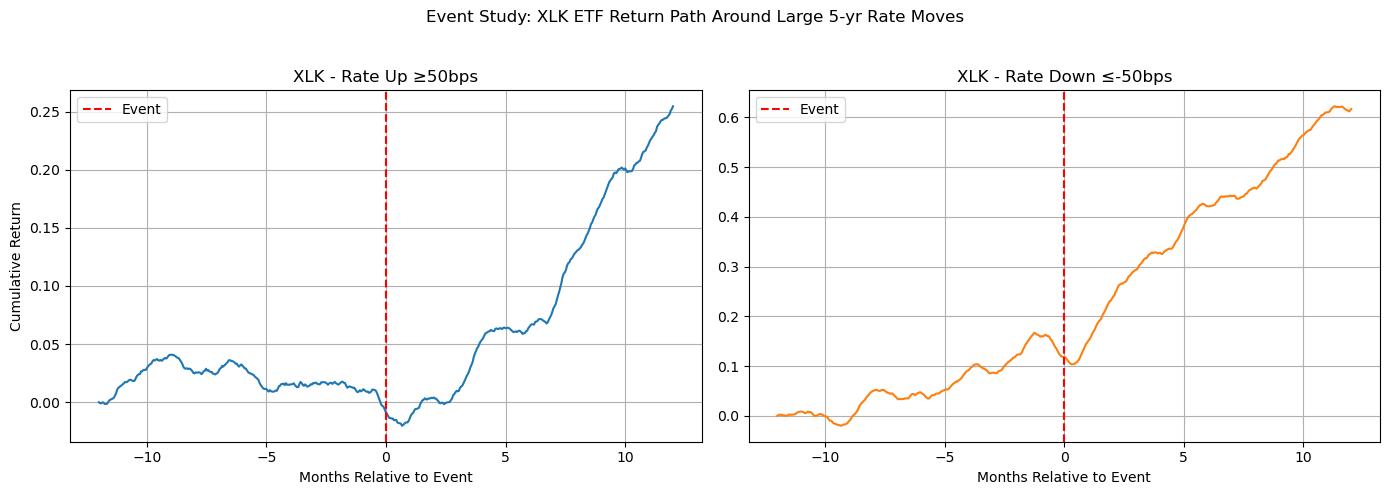

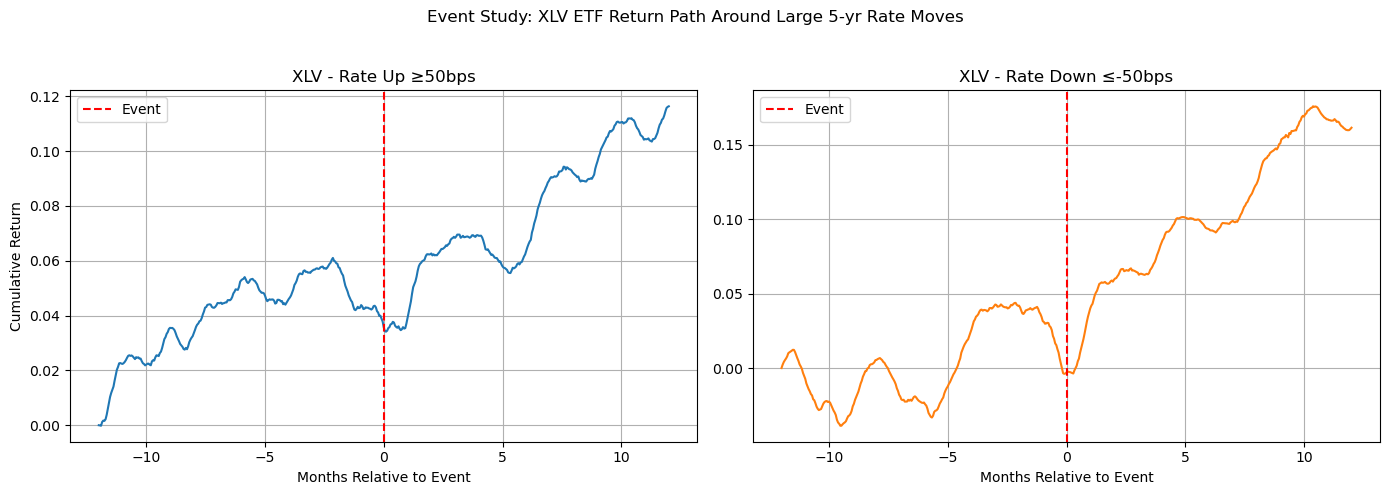

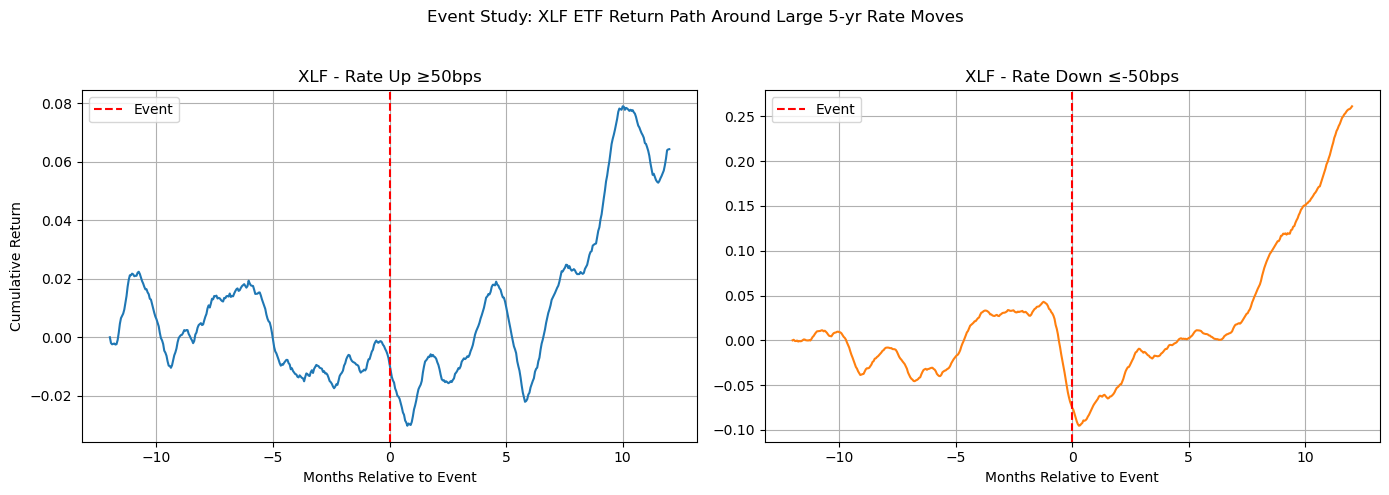

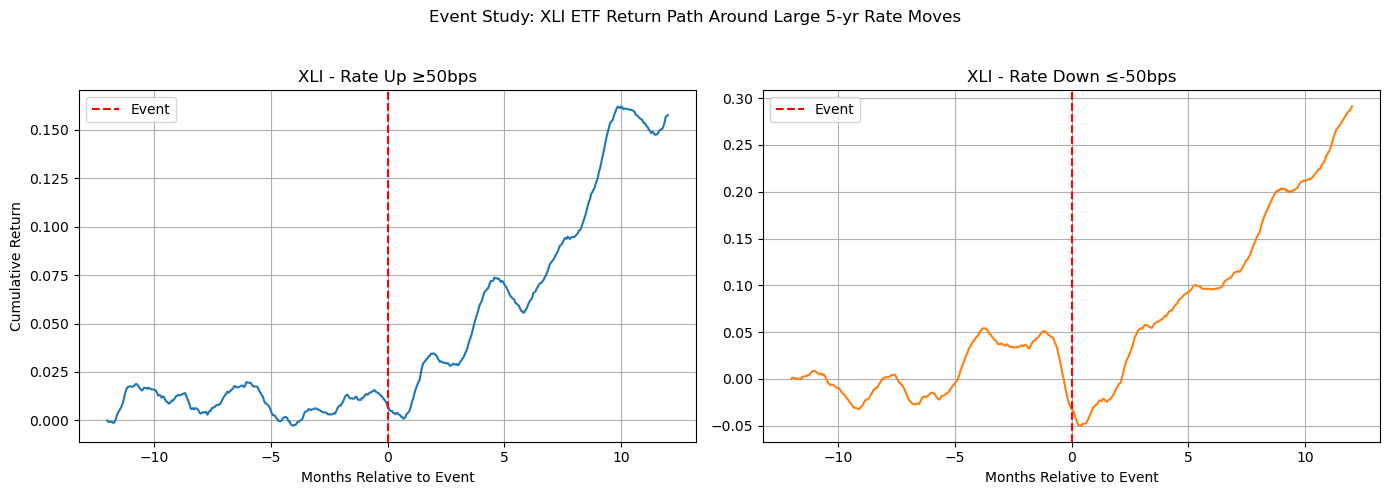

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Use rate_data directly as a Series ---
# (If it's a DataFrame with one column, squeeze to Series)
if isinstance(rate_data, pd.DataFrame):
    rate_data = rate_data.squeeze()

# --- 2. Identify 50 bps moves over 1 month (21 trading days) ---
rate_1m_chg = rate_data.diff(21)
large_move_mask = rate_1m_chg.abs() >= 0.50
large_move_dates = rate_1m_chg.index[large_move_mask]

# --- 3. Build event returns DataFrame for each ETF ---
periods = {'3m': 21*3, '6m': 21*6, '12m': 21*12}
results = []

for symbol in etf_symbols:
    for event_date in large_move_dates:
        if event_date not in etf_data.index:
            continue  # skip if ETF data is missing for that date
        row = {
            'etf': symbol,
            'event_date': event_date,
            'rate_1m_chg': rate_1m_chg.loc[event_date]
        }
        for label, days in periods.items():
            # Forward
            try:
                fwd_idx = etf_data.index.get_loc(event_date) + days
                if fwd_idx < len(etf_data):
                    fwd_return = (etf_data[symbol].iloc[fwd_idx] / etf_data[symbol].loc[event_date]) - 1
                else:
                    fwd_return = np.nan
            except KeyError:
                fwd_return = np.nan
            row[f'{label}_fwd_return'] = fwd_return

            # Backward
            try:
                bwd_idx = etf_data.index.get_loc(event_date) - days
                if bwd_idx >= 0:
                    bwd_return = (etf_data[symbol].loc[event_date] / etf_data[symbol].iloc[bwd_idx]) - 1
                else:
                    bwd_return = np.nan
            except KeyError:
                bwd_return = np.nan
            row[f'{label}_bwd_return'] = bwd_return
        results.append(row)

event_returns = pd.DataFrame(results)

# --- 4. Event study plots for each ETF, split by rate move direction ---
window = 252  # 12 months
months = [-12, -6, -3, 0, 3, 6, 12]
idxs = [(window + int(m*21)) for m in months]  # 21 trading days per month

for symbol in etf_symbols:
    etf_events = event_returns[event_returns['etf'] == symbol]
    up_events = etf_events[etf_events['rate_1m_chg'] > 0]
    down_events = etf_events[etf_events['rate_1m_chg'] < 0]
    aligned_up, aligned_down = [], []
    
    # Up moves
    for event_date in up_events['event_date']:
        idx = etf_data.index.get_loc(event_date)
        if idx - window >= 0 and idx + window < len(etf_data):
            rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
            rel_cum_returns = (1 + rel_returns).cumprod() - 1
            aligned_up.append(rel_cum_returns.values)
    # Down moves
    for event_date in down_events['event_date']:
        idx = etf_data.index.get_loc(event_date)
        if idx - window >= 0 and idx + window < len(etf_data):
            rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
            rel_cum_returns = (1 + rel_returns).cumprod() - 1
            aligned_down.append(rel_cum_returns.values)
    
    days = np.arange(-window, window+1)
    plt.figure(figsize=(14, 5))
    # Up
    if aligned_up:
        mean_up = np.nanmean(aligned_up, axis=0)
        plt.subplot(1, 2, 1)
        plt.plot(days/21, mean_up, color='tab:blue')
        plt.axvline(0, color='red', linestyle='--', label='Event')
        plt.title(f'{symbol} - Rate Up ≥50bps')
        plt.xlabel('Months Relative to Event')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.legend()
    # Down
    if aligned_down:
        mean_down = np.nanmean(aligned_down, axis=0)
        plt.subplot(1, 2, 2)
        plt.plot(days/21, mean_down, color='tab:orange')
        plt.axvline(0, color='red', linestyle='--', label='Event')
        plt.title(f'{symbol} - Rate Down ≤-50bps')
        plt.xlabel('Months Relative to Event')
        plt.grid(True)
        plt.legend()
    plt.suptitle(f'Event Study: {symbol} ETF Return Path Around Large 5-yr Rate Moves')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [8]:
#Granger Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller # For checking stationarity



# If rate_data is a DataFrame, convert it to a Series
if isinstance(rate_data, pd.DataFrame):
    rate_data = rate_data.squeeze()

print("Original ETF Data Head:")
print(etf_data.head())
print("\nOriginal Rate Data Head:")
print(rate_data.head())

# --- CALCULATE DAILY RETURNS ---

# 1. ETF Daily Log Returns (preferred for time series analysis for additivity)
etf_returns = etf_data.apply(lambda x: np.log(x / x.shift(21))) #21 trading days monthly returns 
# Alternatively, simple percentage returns: etf_returns = etf_data.pct_change()

# 2. Interest Rate Daily Change (First Difference)
# Since the rate itself is already a percentage/yield, its first difference is typically stationary.
# We are looking at the *change* in the daily rate, not a "return" on it like stocks.
rate_daily_chg = rate_data.diff(21) #21 trading days monthly returns 

# Combine them into a single DataFrame for easier analysis
# We'll drop NaNs that result from the shift/diff operations
# and ensure they are aligned by date
combined_df = pd.concat([etf_returns, rate_daily_chg.rename('FVX_Daily_Change')], axis=1).dropna()

print("\nCombined Returns/Changes Data Head:")
print(combined_df.head())
print("\nCombined Returns/Changes Data Tail:")
print(combined_df.tail()) # Check if data exists up to recent dates

# --- STATIONARITY CHECK (Augmented Dickey-Fuller Test) ---
# It's good practice to verify stationarity before Granger Causality
print("\n--- Stationarity Test (ADF Test) ---")
print("Null Hypothesis (H0): The time series has a unit root (is non-stationary).")
print("If p-value <= 0.05, reject H0, meaning the series is stationary.")

for col in combined_df.columns:
    adf_result = adfuller(combined_df[col])
    print(f"\nADF Test for {col}:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  P-value: {adf_result[1]:.4f}")
    print(f"  Critical Values: {adf_result[4]}")
    if adf_result[1] <= 0.05:
        print(f"  Conclusion: {col} is likely stationary (Reject H0).")
    else:
        print(f"  Conclusion: {col} is likely non-stationary (Fail to Reject H0). You might need further differencing.")


# --- GRANGER CAUSALITY TEST SETUP ---
print("\n--- Granger Causality Tests ---")
# Let's define a maximum lag for our test. 5-10 trading days is a common starting point
# for daily data, or even more if you suspect longer-term influence.
# We'll test up to 5 days, you might want to experiment with more or fewer based on domain knowledge.
max_lag = 12

# Loop through each ETF to test causality with the interest rate change
for etf_symbol in etf_symbols:
    print(f"\n--- Testing Causality for {etf_symbol} and FVX Daily Change ---")

    # Test 1: Does FVX_Daily_Change Granger-cause ETF Returns?
    # Format: df[['dependent_variable', 'independent_variable']]
    print(f"\nDoes TEX_Daily_Change Granger-cause {etf_symbol} returns?")
    try:
        results_fvx_to_etf = grangercausalitytests(
            combined_df[[etf_symbol, 'FVX_Daily_Change']],
            maxlag=max_lag,
            verbose=False # Set to True to see all statistical output for each lag
        )
        # Extract and print p-values for the F-test for each lag
        for lag in range(1, max_lag + 1):
            p_value = results_fvx_to_etf[lag][0]['ssr_ftest'][1]
            print(f"  Lag {lag}: p-value = {p_value:.4f} "
                  f"({'' if p_value <= 0.05 else 'NOT '}Significant at 5%)")
    except ValueError as e:
        print(f"  Could not perform test: {e}. Check for sufficient data points and no NaNs.")


    # Test 2: Does ETF Returns Granger-cause FVX_Daily_Change?
    print(f"\nDoes {etf_symbol} returns Granger-cause FVX_Daily_Change?")
    try:
        results_etf_to_fvx = grangercausalitytests(
            combined_df[['FVX_Daily_Change', etf_symbol]],
            maxlag=max_lag,
            verbose=False # Set to True to see all statistical output for each lag
        )
        # Extract and print p-values for the F-test for each lag
        for lag in range(1, max_lag + 1,):
            p_value = results_etf_to_fvx[lag][0]['ssr_ftest'][1]
            print(f"  Lag {lag}: p-value = {p_value:.4f} "
                  f"({'' if p_value <= 0.05 else 'NOT '}Significant at 5%)")
    except ValueError as e:
        print(f"  Could not perform test: {e}. Check for sufficient data points and no NaNs.")

print("\n--- Granger Causality Tests Complete ---")
print("Remember: 'Granger Causality' implies predictive power, not necessarily direct cause-and-effect.")
print("A low p-value (e.g., <= 0.05) suggests that the past values of the 'causing' variable help predict the 'effect' variable.")

Original ETF Data Head:
Ticker            XLF        XLI        XLK        XLV
Date                                                  
2015-01-02  16.469656  46.692085  36.315063  57.799503
2015-01-05  16.123346  45.601414  35.760696  57.504730
2015-01-06  15.876939  45.039555  35.329525  57.311039
2015-01-07  16.043427  45.378323  35.628716  58.658546
2015-01-08  16.283186  46.287216  36.411854  59.660740

Original Rate Data Head:
Date
2015-01-02    1.618
2015-01-05    1.568
2015-01-06    1.493
2015-01-07    1.473
2015-01-08    1.496
Name: ^FVX, dtype: float64

Combined Returns/Changes Data Head:
                 XLF       XLI       XLK       XLV  FVX_Daily_Change
Date                                                                
2015-02-03 -0.039593 -0.004079 -0.012190  0.021621            -0.339
2015-02-04 -0.020869  0.011888  0.005154  0.014106            -0.277
2015-02-05  0.004603  0.032843  0.026544  0.034235            -0.193
2015-02-06  0.002074  0.023039  0.014953  0.001865 

C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Lag 1: p-value = 0.4001 (NOT Significant at 5%)
  Lag 2: p-value = 0.2516 (NOT Significant at 5%)
  Lag 3: p-value = 0.3663 (NOT Significant at 5%)
  Lag 4: p-value = 0.4820 (NOT Significant at 5%)
  Lag 5: p-value = 0.2982 (NOT Significant at 5%)
  Lag 6: p-value = 0.4900 (NOT Significant at 5%)
  Lag 7: p-value = 0.4277 (NOT Significant at 5%)
  Lag 8: p-value = 0.3348 (NOT Significant at 5%)
  Lag 9: p-value = 0.1874 (NOT Significant at 5%)
  Lag 10: p-value = 0.2729 (NOT Significant at 5%)
  Lag 11: p-value = 0.2112 (NOT Significant at 5%)
  Lag 12: p-value = 0.0074 (Significant at 5%)

--- Testing Causality for XLV and FVX Daily Change ---

Does TEX_Daily_Change Granger-cause XLV returns?
  Lag 1: p-value = 0.0208 (Significant at 5%)
  Lag 2: p-value = 0.0016 (Significant at 5%)
  Lag 3: p-value = 0.0022 (Significant at 5%)
  Lag 4: p-value = 0.0044 (Significant at 5%)
  Lag 5: p-value = 0.0002 (Significant at 5%)
  Lag 6: p-value = 0.0006 (Significant at 5%)
  Lag 7: p-value = 

C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\tkratt\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Lag 1: p-value = 0.3253 (NOT Significant at 5%)
  Lag 2: p-value = 0.1010 (NOT Significant at 5%)
  Lag 3: p-value = 0.1662 (NOT Significant at 5%)
  Lag 4: p-value = 0.2202 (NOT Significant at 5%)
  Lag 5: p-value = 0.3252 (NOT Significant at 5%)
  Lag 6: p-value = 0.4292 (NOT Significant at 5%)
  Lag 7: p-value = 0.0841 (NOT Significant at 5%)
  Lag 8: p-value = 0.0775 (NOT Significant at 5%)
  Lag 9: p-value = 0.1066 (NOT Significant at 5%)
  Lag 10: p-value = 0.1851 (NOT Significant at 5%)
  Lag 11: p-value = 0.1954 (NOT Significant at 5%)
  Lag 12: p-value = 0.1218 (NOT Significant at 5%)

--- Testing Causality for XLI and FVX Daily Change ---

Does TEX_Daily_Change Granger-cause XLI returns?
  Lag 1: p-value = 0.1219 (NOT Significant at 5%)
  Lag 2: p-value = 0.0614 (NOT Significant at 5%)
  Lag 3: p-value = 0.0566 (NOT Significant at 5%)
  Lag 4: p-value = 0.0080 (Significant at 5%)
  Lag 5: p-value = 0.0178 (Significant at 5%)
  Lag 6: p-value = 0.0380 (Significant at 5%)
  L

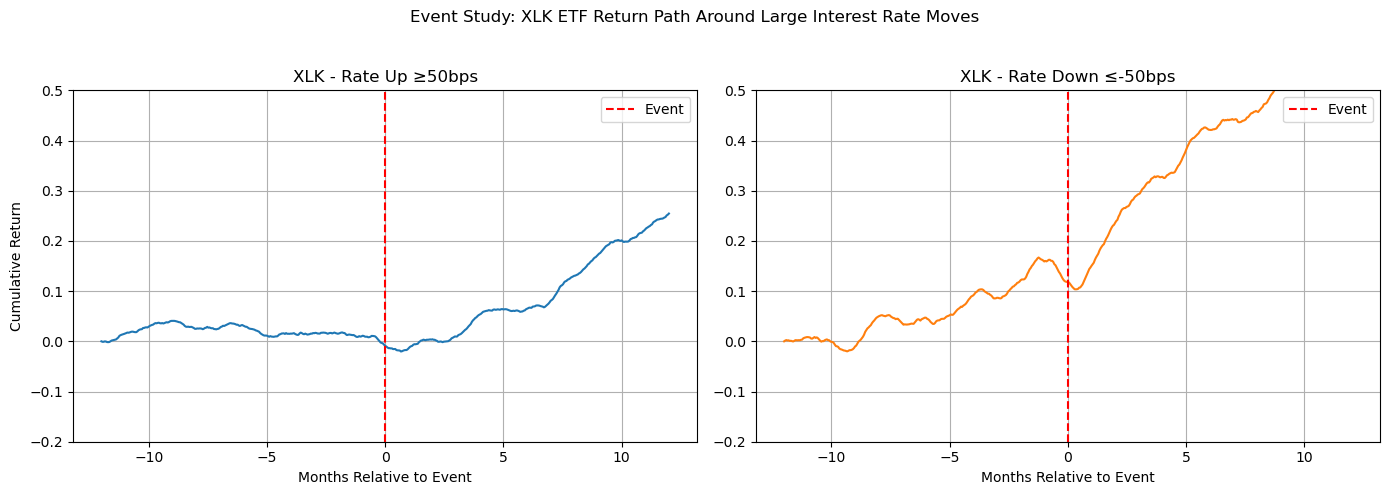

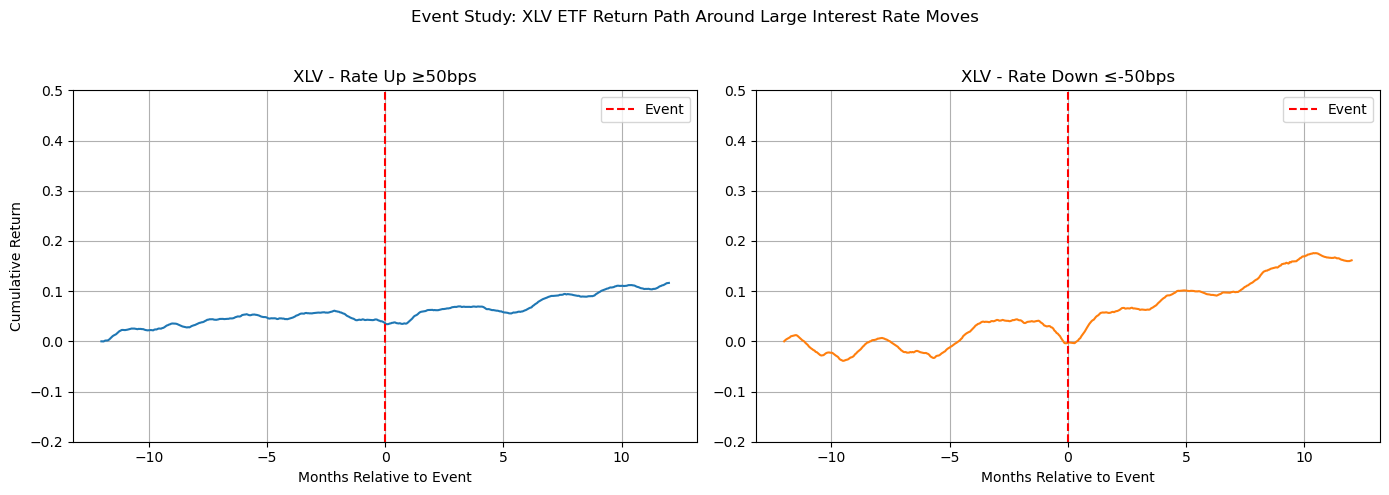

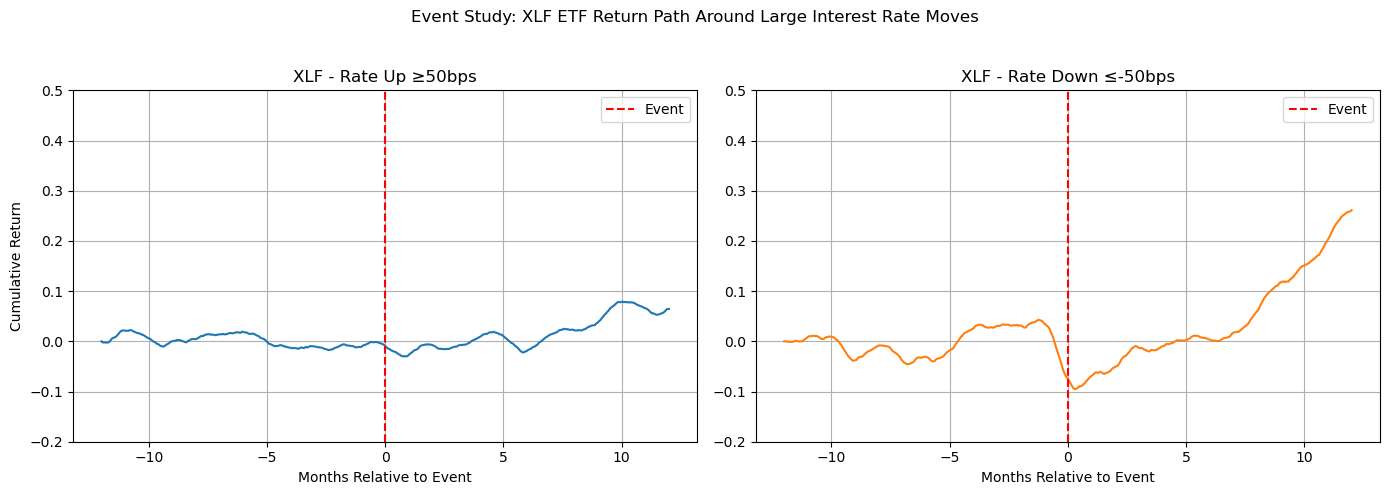

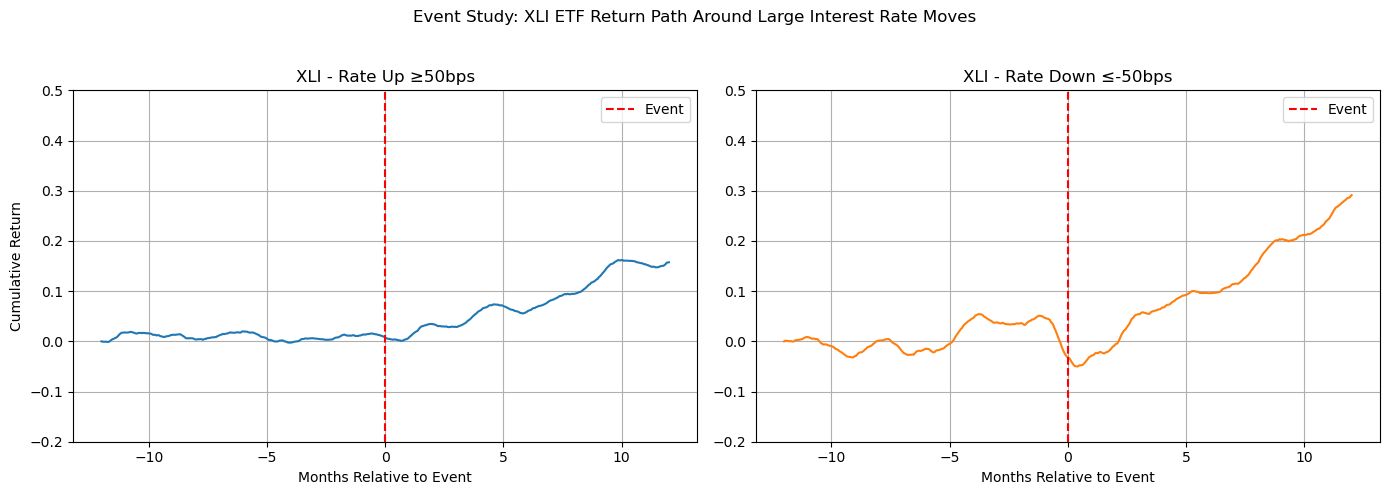

In [9]:
window = 252
custom_ymin = -0.20 # e.g., -0.10 for -10%
custom_ymax = 0.5
# --- Global Y-axis Limits Calculation (Used if custom_ymin/ymax are None) ---
all_cumulative_returns = []

# This loop collects all cumulative return data to determine a consistent Y-axis range
# if custom limits are not provided.
for symbol in etf_symbols:
    etf_events = event_returns[event_returns['etf'] == symbol]
    up_events_for_symbol = etf_events[etf_events['rate_1m_chg'] > 0]
    down_events_for_symbol = etf_events[etf_events['rate_1m_chg'] < 0]

    # Collect cumulative returns for Up moves
    for event_date in up_events_for_symbol['event_date']:
        # Ensure event_date is in the etf_data index
        if event_date in etf_data.index:
            idx = etf_data.index.get_loc(event_date)
            if idx - window >= 0 and idx + window < len(etf_data):
                rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
                rel_cum_returns = (1 + rel_returns).cumprod() - 1
                all_cumulative_returns.extend(rel_cum_returns.values)

    # Collect cumulative returns for Down moves
    for event_date in down_events_for_symbol['event_date']:
        # Ensure event_date is in the etf_data index
        if event_date in etf_data.index:
            idx = etf_data.index.get_loc(event_date)
            if idx - window >= 0 and idx + window < len(etf_data):
                rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
                rel_cum_returns = (1 + rel_returns).cumprod() - 1
                all_cumulative_returns.extend(rel_cum_returns.values)

# Calculate global y-axis limits from all collected cumulative returns
if all_cumulative_returns and (custom_ymin is None or custom_ymax is None):
    global_ymin = np.nanmin(all_cumulative_returns)
    global_ymax = np.nanmax(all_cumulative_returns)
    # Add a little padding
    padding = (global_ymax - global_ymin) * 0.1
    global_ymin -= padding
    global_ymax += padding
elif not all_cumulative_returns and (custom_ymin is None or custom_ymax is None):
    # Default limits if no valid data for path charts and no custom limits provided
    global_ymin, global_ymax = -0.15, 0.15
else:
    # If custom limits are provided, we don't need these calculated values,
    # but initialize them to avoid errors if they're still referenced
    global_ymin = custom_ymin if custom_ymin is not None else -0.15
    global_ymax = custom_ymax if custom_ymax is not None else 0.15


# Determine final Y-axis limits
final_ymin = custom_ymin if custom_ymin is not None else global_ymin
final_ymax = custom_ymax if custom_ymax is not None else global_ymax


# --- Plotting Event Study Paths ---
days = np.arange(-window, window+1) # Days relative to the event, centered at 0

for symbol in etf_symbols:
    etf_events = event_returns[event_returns['etf'] == symbol]
    up_events_for_symbol = etf_events[etf_events['rate_1m_chg'] > 0]
    down_events_for_symbol = etf_events[etf_events['rate_1m_chg'] < 0]
    aligned_up, aligned_down = [], []
    
    # Process Up moves
    for event_date in up_events_for_symbol['event_date']:
        if event_date in etf_data.index: # Check if event_date exists in etf_data index
            idx = etf_data.index.get_loc(event_date)
            # Ensure enough data points exist for the full window
            if idx - window >= 0 and idx + window < len(etf_data):
                rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
                rel_cum_returns = (1 + rel_returns).cumprod() - 1
                aligned_up.append(rel_cum_returns.values)
    
    # Process Down moves
    for event_date in down_events_for_symbol['event_date']:
        if event_date in etf_data.index: # Check if event_date exists in etf_data index
            idx = etf_data.index.get_loc(event_date)
            # Ensure enough data points exist for the full window
            if idx - window >= 0 and idx + window < len(etf_data):
                rel_returns = etf_data[symbol].iloc[idx-window:idx+window+1].pct_change().fillna(0)
                rel_cum_returns = (1 + rel_returns).cumprod() - 1
                aligned_down.append(rel_cum_returns.values)
    
    plt.figure(figsize=(14, 5))
    
    # Plot for Rate Up events
    plt.subplot(1, 2, 1)
    if aligned_up:
        mean_up = np.nanmean(aligned_up, axis=0) # Calculate the average path
        plt.plot(days/21, mean_up, color='tab:blue') # Convert days to months
    plt.axvline(0, color='red', linestyle='--', label='Event') # Vertical line at event
    plt.title(f'{symbol} - Rate Up ≥50bps')
    plt.xlabel('Months Relative to Event')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.ylim(final_ymin, final_ymax) # Apply the determined Y-axis limits
    
    # Plot for Rate Down events
    plt.subplot(1, 2, 2)
    if aligned_down:
        mean_down = np.nanmean(aligned_down, axis=0) # Calculate the average path
        plt.plot(days/21, mean_down, color='tab:orange') # Convert days to months
    plt.axvline(0, color='red', linestyle='--', label='Event') # Vertical line at event
    plt.title(f'{symbol} - Rate Down ≤-50bps')
    plt.xlabel('Months Relative to Event')
    plt.grid(True)
    plt.legend()
    plt.ylim(final_ymin, final_ymax) # Apply the determined Y-axis limits
    
    plt.suptitle(f'Event Study: {symbol} ETF Return Path Around Large Interest Rate Moves')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{symbol}_path_chart.png') # Save the plot

In [11]:
# Calculate returns
etf_returns = etf_data.pct_change()

#For Calulating multiples of avg returns 
key = {"XLF" : 0, "XLI" : 1, "XLK" : 2, "XLV" : 3} 
time_key = {'12M Before' : "12m_Return" , '6M Before' : "6m_Return", '3M Before' : "3m_Return", '3M Forward' : "3m_Return", '6M Forward': "6m_Return", '12M Forward': "12m_Return" }


# Calculate average 3, 6, and 12-month returns
# 3-month return (63 trading days)
avg_3m_returns = etf_returns.rolling(window=63).apply(lambda x: (1 + x).prod() - 1, raw=True)
# 6-month return (126 trading days)
avg_6m_returns = etf_returns.rolling(window=126).apply(lambda x: (1 + x).prod() - 1, raw=True)
# 12-month return (252 trading days)
avg_12m_returns = etf_returns.rolling(window=252).apply(lambda x: (1 + x).prod() - 1, raw=True)

# Combine the results into a single DataFrame
# The .iloc[-1] gets the most recent values for each rolling calculation
avg_returns_df = pd.DataFrame({
    '3m_Return': avg_3m_returns.mean(),
    '6m_Return': avg_6m_returns.mean(),
    '12m_Return': avg_12m_returns.mean()
})

XLF = 0
XLI = 1
XLK = 2
XLV = 3 
print(round(avg_returns_df["3m_Return"].iloc[XLF],4))
print("\nAverage 3, 6, and 12-Month Returns:")

print(avg_returns_df)





0.0325

Average 3, 6, and 12-Month Returns:
        3m_Return  6m_Return  12m_Return
Ticker                                  
XLF      0.032474   0.066712    0.138680
XLI      0.029850   0.060922    0.130932
XLK      0.048277   0.101437    0.224702
XLV      0.022234   0.044781    0.098852
